# Image Classification with finetuned GoogleLeNet 

In my previous post [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) I built a small convolutional neural network (CNN) to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). My goal was to demonstrate how easy one can construct a neural network with descent accuracy (around 70%). However, for many real word problems building CNNs from scratch might not be practical. For instance, in a recent [kaggle](http://kaggle.com/) challenge called [Dog vs Cat](https://www.kaggle.com/c/dogs-vs-cats) the competitors were asked to correctly classify images of dogs and cats. In an insightful [interview](http://blog.kaggle.com/2017/04/03/dogs-vs-cats-redux-playground-competition-winners-interview-bojan-tunguz/) the winner of that challenge explained that he didn't rely solely on a CNN that he built from scratch. Instead he got his hands on multiple models already trained with large datasets and applied some "finetuning" in order to make these fit for the specific goal of classifying cats and dogs. So how does this work? The idea is simple. There are hundreds of models already trained on a specific dataset. The largest repository I know is the [Model Zoo Github Repo](https://github.com/BVLC/caffe/wiki/Model-Zoo). There are also the models from the [Tensorflow Slim Project](https://github.com/tensorflow/models/tree/master/slim). So the goal is to select a model that is already trained on a dataset that is similar to the one you are interested in. After selecting the model one has to apply some "finetuning" on it. Interested? Well continue reading, as this is exactly what I am going to do in this post.  

# Cifar-10 Image Dataset

If you are already familiar with my previous post [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html), you might want to skip the next sections and go directly to **Converting datasets to .tfrecord**.

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 10 categories - airplanes, dogs, cats, and other objects. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. Here are the classes in the dataset, as well as 10 random images from each:
<img src="files/dataset_overview.jpg">
The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

## Download the dataset
First, few lines of code will download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
# DOWNLOAD DATASET 
from urllib.request import urlretrieve
import os
from tqdm import tqdm
import tarfile

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not os.path.isdir('cifar-10-batches-py'):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [05:41, 499KB/s]                               


## Data Overview
The dataset is broken into batches - this is especially useful if one is to train the network on a laptop as it will probably prevent it from running out of memory. I only had 12 GB on mine and a single batch used around 3.2 GB - it wouldn't be possible to load everything at once. Nevertheless, the CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data. Following functions can be used to view different images by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

In [2]:
import pickle
import matplotlib.pyplot as plt

# The names of the classes in the dataset.
CLASS_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

def load_cfar10_batch(batch_id):

    with open(os.path.join('cifar-10-batches-py','data_batch_' 
              + str(batch_id)), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(features, labels, sample_id):

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'
              .format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, CLASS_NAMES[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)
    plt.show()

Let's check the first couple of images of each batch. The lines below can be easily modified to show an arbitary image from any batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 0:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


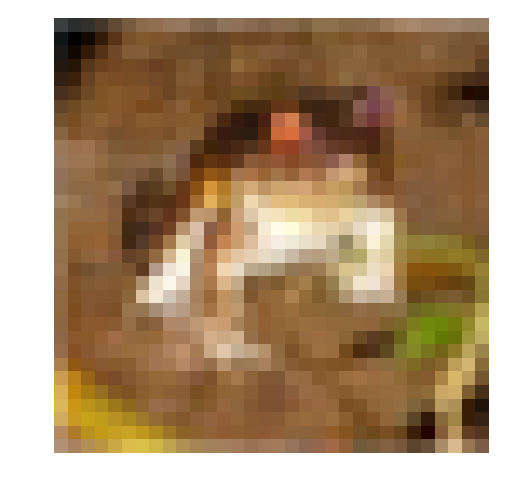


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 1:
Image - Min Value: 5 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


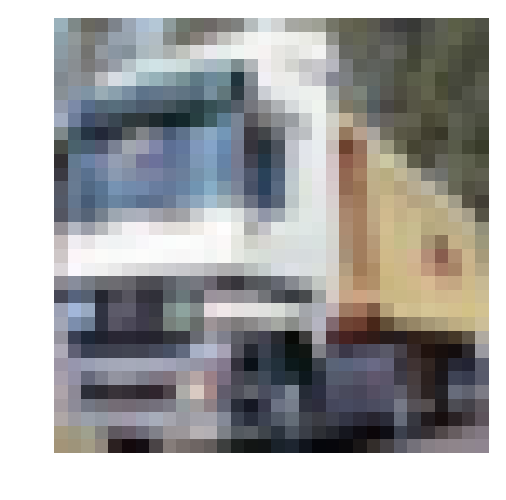


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 0:
Image - Min Value: 5 Max Value: 225
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


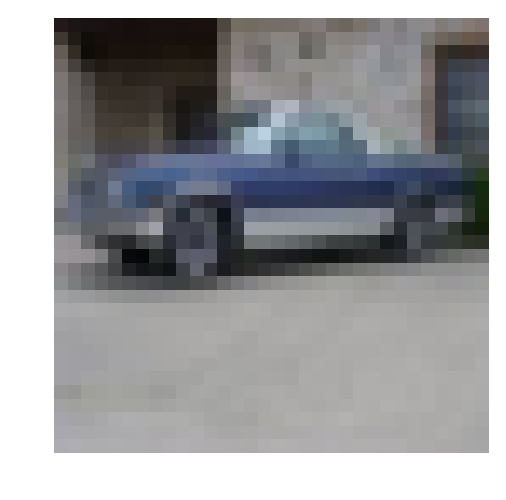


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 1:
Image - Min Value: 2 Max Value: 247
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


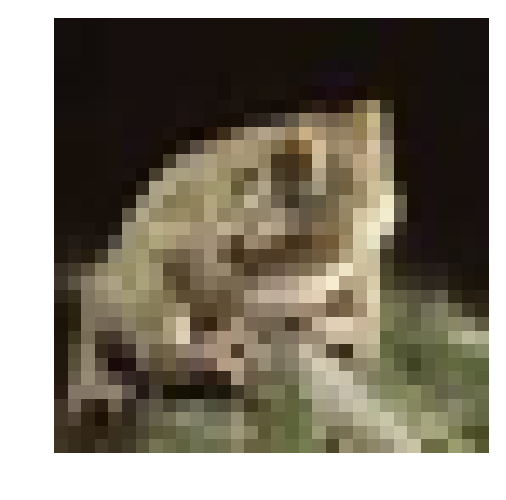


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 0:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


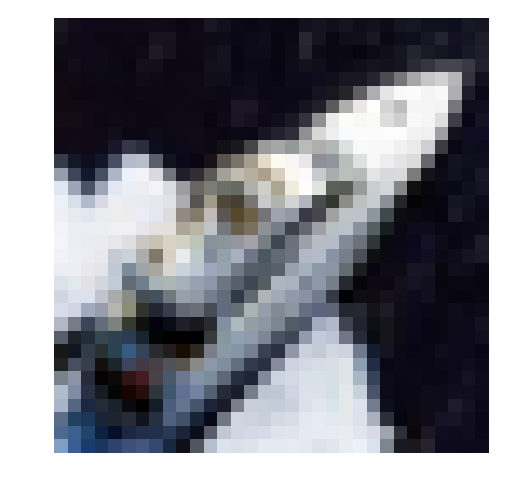


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 1:
Image - Min Value: 15 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 5 Name: dog


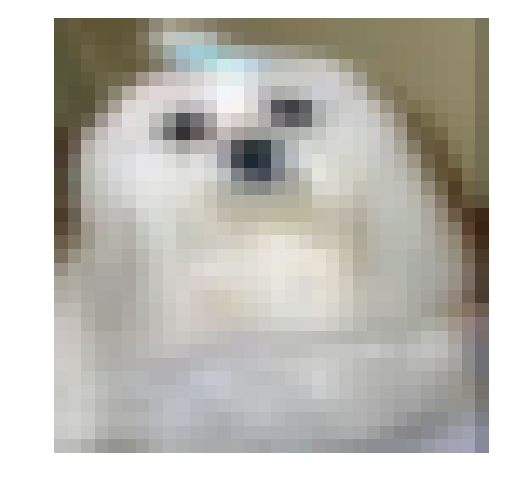


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 0:
Image - Min Value: 34 Max Value: 203
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


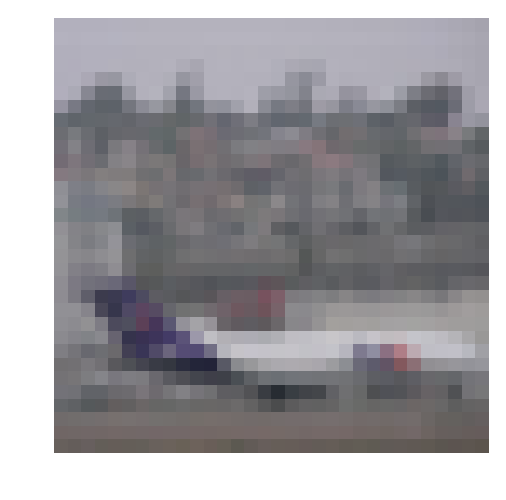


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 1:
Image - Min Value: 0 Max Value: 246
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


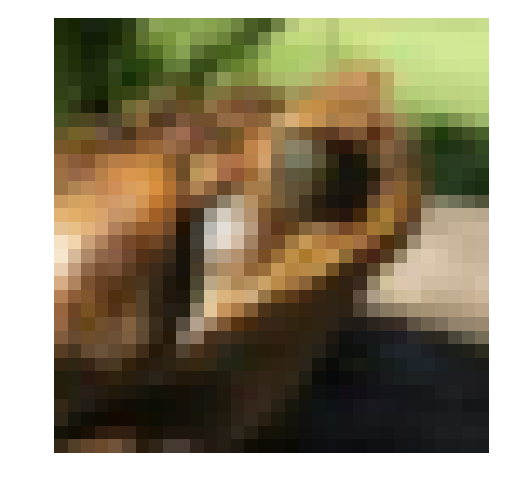


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 0:
Image - Min Value: 2 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


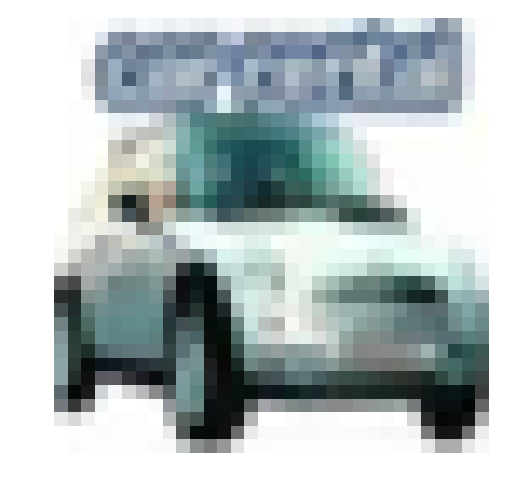


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 1:
Image - Min Value: 1 Max Value: 244
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


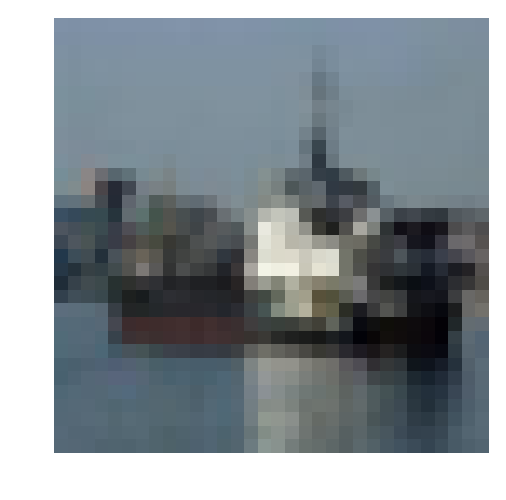

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

for batch_id in range(1,6):
    features, labels = load_cfar10_batch(batch_id)
    for image_id in range(0,2):
        display_stats(features, labels, image_id)

del features, labels # free memory  

# Converting datasets to .tfrecord
Next we convert the datasets to tfrecords. This would allow for the easier further processing by Tensorflow. While the neural network constructed in [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) expected images with size 32x32, the CNN we are going to use here expects an input size of 224x224. Nevertheless, it is not necessary to convert all 60000 images to the target size of 224x224 as this would requre much more of your disk space. Converting the data to tfrecord would actually shrink the dataset size (lossless compression) and allow for the use of tensorflow's preprocessing pipeline and a dynamic conversion to the desired target size of 224x224 at training time.

In [4]:
import sys
import dataset_utils
import tensorflow as tf

IMAGE_SIZE = 32
RGB_CHANNELS = 3

def add_to_tfrecord(filename, tfrecord_writer, offset=0):
    
    with open(filename, mode='rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    images = data['data']
    num_images = images.shape[0]

    images = images.reshape((num_images, RGB_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
    labels = data['labels']

    with tf.Graph().as_default():
        image_placeholder = tf.placeholder(dtype=tf.uint8)
        encoded_image = tf.image.encode_png(image_placeholder)

        with tf.Session('') as sess:

            for j in range(num_images):
                sys.stdout.write('\r>> Reading file [%s] image %d/%d' % \
                    (filename, offset + j + 1, offset + num_images))
                sys.stdout.flush()

                image = np.squeeze(images[j]).transpose((1, 2, 0))
                label = labels[j]

                png_string = sess.run(encoded_image,\
                         feed_dict={image_placeholder: image})

                example = dataset_utils.image_to_tfexample(\
                    png_string, 'png'.encode('utf-8'), IMAGE_SIZE, IMAGE_SIZE, label)
                tfrecord_writer.write(example.SerializeToString())

    return offset + num_images


if not os.path.isdir('tfrecord'):
    # make the directory
    os.mkdir('tfrecord')
    # write all 5 batches into single training tfrecord
    with tf.python_io.TFRecordWriter(os.path.join('tfrecord', 'cifar-10-training-tfrecord')) as tfrecord_writer:
        offset = 0
        for i in range(1, 6): # Train batches are data_batch_1 ... data_batch_5
            filename = os.path.join('cifar-10-batches-py', 'data_batch_%d' % (i))
            offset = add_to_tfrecord(filename, tfrecord_writer, offset)

    # Next, process the testing data:
    with tf.python_io.TFRecordWriter(os.path.join('tfrecord', 'cifar-10-test-tfrecord')) as tfrecord_writer:
        filename = os.path.join('cifar-10-batches-py', 'test_batch')
        add_to_tfrecord(filename, tfrecord_writer)

    # Finally, write the labels file:
    labels_to_class_names = dict(zip(range(len(CLASS_NAMES)), CLASS_NAMES))

    with tf.gfile.Open(os.path.join('tfrecord', 'labels.txt'), 'w') as f:
        for label in labels_to_class_names:
            class_name = labels_to_class_names[label]
            f.write('%d:%s\n' % (label, class_name))

>> Reading file [cifar-10-batches-py/test_batch] image 10000/1000000

# Downloading GoogleLeNet
As previously elaborated, selecting a proper network to "finetune" is very important. For this post I selected GoogleLeNet that is also known as InceptionV1. An overview on other fully trained neural networks by Google is available in the [Tensorflow Slim Project](https://github.com/tensorflow/models/tree/master/slim). All four versions of inception were trained on part of the [ImageNet](http://www.image-net.org/challenges/LSVRC/2012/) dataset, whick consists of more than 10,000,000 images and over 10,000 categories. The ten categories in Cifar-10 are covered in ImageNet to some extent. Hence, the Inception models should be capable of recognizing images from Cifar-10 after finetuning. For this post I chose InceptionV1, as it is much smaller network than e.g. InceptionV4 and would require far less time and processing power when finetuning. The remaining code could be very easily modified to use the other versions of Inception (given you have time and several GPUs to your dispolsal).

In [5]:
inceptionv1_archive = os.path.join('model', 'inception_v1_2016_08_28.tar.gz')

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isdir('model'):
    # create directory to store model
    os.mkdir('model')
    # download the model
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='InceptionV4') as pbar:
        urlretrieve(
            # I hope this url stays there
            'http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz',
            inceptionv1_archive,
            pbar.hook)

    with tarfile.open(inceptionv1_archive) as tar:
        tar.extractall('model')
        tar.close()

InceptionV4: 24.6MB [00:14, 1.74MB/s]                            


# Finetuning GoogleLeNet (InceptionV1)
First we define two functions for loading a batch and loading the dataset.

In [6]:
import inception_preprocessing

def load_batch(dataset, batch_size, height, width, is_training=False):
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(
        image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

def get_dataset(dataset_file_name, train_sample_size):

    ITEMS_TO_DESCRIPTIONS = {
        'image': 'A [32 x 32 x 3] color image.',
        'label': 'A single integer between 0 and 9',
    }

    keys_to_features = {
          'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
          'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
          'image/class/label': tf.FixedLenFeature(
              [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    items_to_handlers = {
          'image': slim.tfexample_decoder.Image(shape=[IMAGE_SIZE, IMAGE_SIZE, 3]),
          'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    labels_to_names = {}
    for i in range(0, len(CLASS_NAMES)):
        labels_to_names[i] = CLASS_NAMES[i]

    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    return slim.dataset.Dataset(
          data_sources=dataset_file_name,
          reader=tf.TFRecordReader,
          decoder=decoder,
          num_samples=train_sample_size,
          items_to_descriptions=ITEMS_TO_DESCRIPTIONS,
          num_classes=len(CLASS_NAMES),
          labels_to_names=labels_to_names)

Next we define a function for loading the pretrained model that has been previously downloaded. The function also specifies which variables should be restored from the pretrained model. The actual layers of the neural network are contained in those varaibles. This is where "finetuning" happens. The process of "finetuning" is selecting layers from the nueral network that should be retrained, while leaving the others unchanged. In a neural network, early layers capture low level details. Each subsequent layer uses the lower level details from its predecessors (e.g. a nose, an eye and a mouth) to caputre a higher level detail (e.g. a dogs or cats face). For more detailed explanation of this matter I recommend [Visualizing and Understanding Deep Neural Networks by Matt Zeiler](https://www.youtube.com/watch?v=ghEmQSxT6tw). Anyway, when finetuning we will only train the last few layers of the network. The functions below will not only load the model, but will also create a small log file. The log file [tf_inception_vars.txt](tf_inception variables.txt) shows all tensorflow variables and indicates which variables would remain unchanged and which would be used in the finetuning process.

In [7]:
def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/Mixed_5c"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]
    
    variables_to_restore = []
    variables_to_retrain = []
    
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)
        else:
            variables_to_retrain.append(var)
    
    with tf.gfile.Open('tf_inception_vars.txt', 'w') as f:
        for var in variables_to_restore:
             f.write('%s ::RESTORED FROM CHECKPOINT\n' % (var))
        for var in variables_to_retrain:
             f.write('%s ::SELECTED FOR RETRAINING\n' % (var))

    return slim.assign_from_checkpoint_fn(
      os.path.join('model','inception_v1.ckpt'), variables_to_restore)

Finally, we select a batch size, and the number of steps and we are good to go and start the finetunning process.

In [8]:
from inception_v1 import inception_v1
from inception_v1 import inception_v1_arg_scope

TRAIN_SAMPLES = 50000
INCEPTION_IMAGE_SIZE = 224
BATCH_SIZE = 128
NUMBER_OF_STEPS = 2000

slim = tf.contrib.slim

TRAINED_MODEL_DIR = 'inceptionV1_cifar10_finetuned'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    train_dataset = get_dataset(
        os.path.join('tfrecord','cifar-10-training-tfrecord'), TRAIN_SAMPLES)
    
    images, _, labels = load_batch(
       train_dataset, BATCH_SIZE, INCEPTION_IMAGE_SIZE, INCEPTION_IMAGE_SIZE)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v1_arg_scope()):
        logits, _ = inception_v1(images, num_classes=train_dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, train_dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=TRAINED_MODEL_DIR,
        init_fn=get_init_fn(),
        number_of_steps=NUMBER_OF_STEPS)
        
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 1: loss = 2.6516 (106.07 sec/step)
INFO:tensorflow:global step 2: loss = 6.2414 (40.32 sec/step)
INFO:tensorflow:global step 3: loss = 4.3566 (33.22 sec/step)
INFO:tensorflow:global step 4: loss = 3.6533 (31.74 sec/step)
INFO:tensorflow:global step 5: loss = 3.1320 (30.12 sec/step)
INFO:tensorflow:global step 6: loss = 2.8293 (30.32 sec/step)
INFO:tensorflow:global step 

INFO:tensorflow:global step 95: loss = 2.5095 (30.15 sec/step)
INFO:tensorflow:global step 96: loss = 2.9582 (30.53 sec/step)
INFO:tensorflow:global step 97: loss = 2.4907 (30.68 sec/step)
INFO:tensorflow:global step 98: loss = 2.5629 (30.40 sec/step)
INFO:tensorflow:global step 99: loss = 2.6000 (30.34 sec/step)
INFO:tensorflow:global step 100: loss = 2.4721 (30.59 sec/step)
INFO:tensorflow:global step 101: loss = 2.5131 (29.99 sec/step)
INFO:tensorflow:global step 102: loss = 2.5040 (30.37 sec/step)
INFO:tensorflow:global step 103: loss = 2.5204 (30.43 sec/step)
INFO:tensorflow:global step 104: loss = 2.4362 (30.29 sec/step)
INFO:tensorflow:global step 105: loss = 2.5496 (30.13 sec/step)
INFO:tensorflow:global step 106: loss = 2.7024 (30.89 sec/step)
INFO:tensorflow:global step 107: loss = 3.0493 (30.55 sec/step)
INFO:tensorflow:global step 108: loss = 2.6591 (30.81 sec/step)
INFO:tensorflow:global step 109: loss = 2.6645 (30.65 sec/step)
INFO:tensorflow:global_step/sec: 0.0299871
IN

INFO:tensorflow:global step 221: loss = 2.0991 (30.09 sec/step)
INFO:tensorflow:global step 222: loss = 2.0592 (30.25 sec/step)
INFO:tensorflow:global step 223: loss = 2.2008 (30.27 sec/step)
INFO:tensorflow:global step 224: loss = 2.0607 (42.57 sec/step)
INFO:tensorflow:global step 225: loss = 2.1518 (30.22 sec/step)
INFO:tensorflow:global step 226: loss = 2.0654 (30.08 sec/step)
INFO:tensorflow:global step 227: loss = 2.1481 (30.41 sec/step)
INFO:tensorflow:global step 228: loss = 2.1871 (30.03 sec/step)
INFO:tensorflow:global step 229: loss = 2.1889 (30.31 sec/step)
INFO:tensorflow:global step 230: loss = 2.1329 (30.85 sec/step)
INFO:tensorflow:global step 231: loss = 2.1068 (30.40 sec/step)
INFO:tensorflow:global step 232: loss = 2.0790 (31.59 sec/step)
INFO:tensorflow:global step 233: loss = 2.2622 (30.32 sec/step)
INFO:tensorflow:global step 234: loss = 2.1565 (30.74 sec/step)
INFO:tensorflow:global step 235: loss = 2.2389 (30.05 sec/step)
INFO:tensorflow:global step 236: loss = 

INFO:tensorflow:global step 350: loss = 1.6634 (36.01 sec/step)
INFO:tensorflow:global step 351: loss = 1.6730 (104.01 sec/step)
INFO:tensorflow:global step 352: loss = 1.8933 (35.59 sec/step)
INFO:tensorflow:global step 353: loss = 1.9071 (36.59 sec/step)
INFO:tensorflow:global step 354: loss = 2.2237 (36.61 sec/step)
INFO:tensorflow:global step 355: loss = 2.2786 (37.17 sec/step)
INFO:tensorflow:global step 356: loss = 2.3954 (33.94 sec/step)
INFO:tensorflow:global step 357: loss = 1.8521 (33.62 sec/step)
INFO:tensorflow:global step 358: loss = 1.9856 (33.96 sec/step)
INFO:tensorflow:global step 359: loss = 2.0853 (33.59 sec/step)
INFO:tensorflow:global step 360: loss = 2.0273 (33.19 sec/step)
INFO:tensorflow:global step 361: loss = 2.2128 (34.62 sec/step)
INFO:tensorflow:global step 362: loss = 2.0298 (33.99 sec/step)
INFO:tensorflow:global step 363: loss = 2.1566 (34.27 sec/step)
INFO:tensorflow:global step 364: loss = 1.9339 (35.45 sec/step)
INFO:tensorflow:global step 365: loss =

INFO:tensorflow:global step 478: loss = 1.7650 (32.97 sec/step)
INFO:tensorflow:global step 479: loss = 1.8645 (33.65 sec/step)
INFO:tensorflow:global step 480: loss = 2.0202 (33.41 sec/step)
INFO:tensorflow:global step 481: loss = 2.1051 (31.91 sec/step)
INFO:tensorflow:global step 482: loss = 2.0362 (33.61 sec/step)
INFO:tensorflow:global step 483: loss = 1.9362 (60.21 sec/step)
INFO:tensorflow:global step 484: loss = 2.0215 (33.61 sec/step)
INFO:tensorflow:global step 485: loss = 1.9292 (32.11 sec/step)
INFO:tensorflow:global step 486: loss = 1.9138 (33.48 sec/step)
INFO:tensorflow:global step 487: loss = 2.0056 (32.79 sec/step)
INFO:tensorflow:global step 488: loss = 2.0112 (33.53 sec/step)
INFO:tensorflow:global step 489: loss = 1.9966 (32.18 sec/step)
INFO:tensorflow:global step 490: loss = 1.9672 (36.27 sec/step)
INFO:tensorflow:global step 491: loss = 1.8513 (36.31 sec/step)
INFO:tensorflow:global step 492: loss = 1.8848 (35.74 sec/step)
INFO:tensorflow:global step 493: loss = 

INFO:tensorflow:global step 607: loss = 1.6078 (33.24 sec/step)
INFO:tensorflow:global step 608: loss = 1.7036 (33.90 sec/step)
INFO:tensorflow:global step 609: loss = 1.6902 (34.97 sec/step)
INFO:tensorflow:global step 610: loss = 1.6012 (37.62 sec/step)
INFO:tensorflow:global step 611: loss = 1.5844 (36.01 sec/step)
INFO:tensorflow:global step 612: loss = 1.6554 (35.29 sec/step)
INFO:tensorflow:global step 613: loss = 1.7383 (48.77 sec/step)
INFO:tensorflow:global step 614: loss = 1.5621 (35.49 sec/step)
INFO:tensorflow:global step 615: loss = 1.6895 (33.70 sec/step)
INFO:tensorflow:global step 616: loss = 1.7133 (34.59 sec/step)
INFO:tensorflow:global step 617: loss = 1.6729 (35.34 sec/step)
INFO:tensorflow:global step 618: loss = 1.7972 (36.43 sec/step)
INFO:tensorflow:global step 619: loss = 1.5556 (34.62 sec/step)
INFO:tensorflow:global step 620: loss = 1.7847 (35.55 sec/step)
INFO:tensorflow:global step 621: loss = 1.6116 (35.93 sec/step)
INFO:tensorflow:global step 622: loss = 

INFO:tensorflow:global step 736: loss = 1.6182 (32.33 sec/step)
INFO:tensorflow:global step 737: loss = 1.5436 (31.70 sec/step)
INFO:tensorflow:global step 738: loss = 1.4359 (32.07 sec/step)
INFO:tensorflow:global step 739: loss = 1.4728 (32.56 sec/step)
INFO:tensorflow:global step 740: loss = 1.4573 (32.56 sec/step)
INFO:tensorflow:global step 741: loss = 1.4315 (32.04 sec/step)
INFO:tensorflow:global step 742: loss = 1.4436 (32.36 sec/step)
INFO:tensorflow:global step 743: loss = 1.4025 (32.40 sec/step)
INFO:tensorflow:global step 744: loss = 1.6127 (32.85 sec/step)
INFO:tensorflow:global step 745: loss = 1.6292 (31.83 sec/step)
INFO:tensorflow:global step 746: loss = 1.3551 (32.37 sec/step)
INFO:tensorflow:global step 747: loss = 1.5952 (32.39 sec/step)
INFO:tensorflow:global step 748: loss = 1.3205 (32.75 sec/step)
INFO:tensorflow:global step 749: loss = 1.5027 (32.05 sec/step)
INFO:tensorflow:global step 750: loss = 1.5397 (31.89 sec/step)
INFO:tensorflow:global step 751: loss = 

INFO:tensorflow:global step 865: loss = 1.3439 (32.05 sec/step)
INFO:tensorflow:global step 866: loss = 1.3363 (32.69 sec/step)
INFO:tensorflow:global step 867: loss = 1.3846 (32.01 sec/step)
INFO:tensorflow:global step 868: loss = 1.3769 (32.40 sec/step)
INFO:tensorflow:global step 869: loss = 1.4877 (32.49 sec/step)
INFO:tensorflow:global step 870: loss = 1.3373 (33.05 sec/step)
INFO:tensorflow:global step 871: loss = 1.3539 (32.06 sec/step)
INFO:tensorflow:global step 872: loss = 1.3675 (32.19 sec/step)
INFO:tensorflow:global step 873: loss = 1.2908 (33.25 sec/step)
INFO:tensorflow:global step 874: loss = 1.4224 (32.36 sec/step)
INFO:tensorflow:global step 875: loss = 1.4320 (55.03 sec/step)
INFO:tensorflow:global step 876: loss = 1.2960 (32.38 sec/step)
INFO:tensorflow:global step 877: loss = 1.4001 (32.18 sec/step)
INFO:tensorflow:global step 878: loss = 1.2674 (32.02 sec/step)
INFO:tensorflow:global step 879: loss = 1.3578 (32.07 sec/step)
INFO:tensorflow:global step 880: loss = 

INFO:tensorflow:global step 994: loss = 1.4158 (32.27 sec/step)
INFO:tensorflow:global step 995: loss = 1.2055 (32.38 sec/step)
INFO:tensorflow:global step 996: loss = 1.3294 (32.38 sec/step)
INFO:tensorflow:global step 997: loss = 1.3730 (32.29 sec/step)
INFO:tensorflow:global step 998: loss = 1.5251 (33.33 sec/step)
INFO:tensorflow:global step 999: loss = 1.2979 (56.14 sec/step)
INFO:tensorflow:global step 1000: loss = 1.3843 (32.14 sec/step)
INFO:tensorflow:global step 1001: loss = 1.2335 (31.91 sec/step)
INFO:tensorflow:global step 1002: loss = 1.2740 (32.26 sec/step)
INFO:tensorflow:global step 1003: loss = 1.3132 (32.53 sec/step)
INFO:tensorflow:global step 1004: loss = 1.2859 (32.18 sec/step)
INFO:tensorflow:global step 1005: loss = 1.4688 (32.10 sec/step)
INFO:tensorflow:global step 1006: loss = 1.3522 (32.38 sec/step)
INFO:tensorflow:global step 1007: loss = 1.1980 (32.24 sec/step)
INFO:tensorflow:global step 1008: loss = 1.3392 (32.72 sec/step)
INFO:tensorflow:global step 100

INFO:tensorflow:global step 1121: loss = 1.3175 (32.95 sec/step)
INFO:tensorflow:global step 1122: loss = 1.1630 (32.15 sec/step)
INFO:tensorflow:global step 1123: loss = 1.2152 (58.99 sec/step)
INFO:tensorflow:global step 1124: loss = 1.1132 (32.64 sec/step)
INFO:tensorflow:global step 1125: loss = 1.2081 (33.13 sec/step)
INFO:tensorflow:global step 1126: loss = 1.2073 (32.35 sec/step)
INFO:tensorflow:global step 1127: loss = 1.2156 (32.24 sec/step)
INFO:tensorflow:global step 1128: loss = 1.2476 (32.49 sec/step)
INFO:tensorflow:global step 1129: loss = 1.1360 (32.98 sec/step)
INFO:tensorflow:global step 1130: loss = 1.1951 (32.77 sec/step)
INFO:tensorflow:global step 1131: loss = 1.4838 (32.33 sec/step)
INFO:tensorflow:global step 1132: loss = 1.2991 (32.57 sec/step)
INFO:tensorflow:global step 1133: loss = 1.4904 (33.02 sec/step)
INFO:tensorflow:global step 1134: loss = 1.4313 (32.75 sec/step)
INFO:tensorflow:global step 1135: loss = 1.2672 (32.80 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1248: loss = 1.2499 (32.65 sec/step)
INFO:tensorflow:global step 1249: loss = 1.3851 (33.42 sec/step)
INFO:tensorflow:global step 1250: loss = 1.5536 (33.14 sec/step)
INFO:tensorflow:global step 1251: loss = 1.2472 (33.64 sec/step)
INFO:tensorflow:global step 1252: loss = 1.1296 (32.77 sec/step)
INFO:tensorflow:global step 1253: loss = 1.3719 (35.47 sec/step)
INFO:tensorflow:global step 1254: loss = 1.2806 (36.37 sec/step)
INFO:tensorflow:global step 1255: loss = 1.2581 (33.13 sec/step)
INFO:tensorflow:global step 1256: loss = 1.2268 (33.00 sec/step)
INFO:tensorflow:global step 1257: loss = 1.2237 (33.36 sec/step)
INFO:tensorflow:global step 1258: loss = 1.3245 (33.06 sec/step)
INFO:tensorflow:global step 1259: loss = 1.2228 (32.68 sec/step)
INFO:tensorflow:global step 1260: loss = 1.3141 (32.18 sec/step)
INFO:tensorflow:global step 1261: loss = 1.1791 (33.22 sec/step)
INFO:tensorflow:global step 1262: loss = 1.2391 (47.42 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1375: loss = 1.4057 (32.34 sec/step)
INFO:tensorflow:global step 1376: loss = 1.3159 (32.11 sec/step)
INFO:tensorflow:global step 1377: loss = 1.1186 (31.67 sec/step)
INFO:tensorflow:global step 1378: loss = 1.1607 (31.77 sec/step)
INFO:tensorflow:global step 1379: loss = 1.0721 (32.09 sec/step)
INFO:tensorflow:global step 1380: loss = 1.2416 (32.38 sec/step)
INFO:tensorflow:global step 1381: loss = 1.2076 (31.99 sec/step)
INFO:tensorflow:global step 1382: loss = 1.3346 (32.06 sec/step)
INFO:tensorflow:global step 1383: loss = 1.3339 (32.21 sec/step)
INFO:tensorflow:global step 1384: loss = 1.3571 (32.28 sec/step)
INFO:tensorflow:global step 1385: loss = 1.2770 (32.11 sec/step)
INFO:tensorflow:global step 1386: loss = 1.2759 (56.33 sec/step)
INFO:tensorflow:global step 1387: loss = 1.2441 (32.74 sec/step)
INFO:tensorflow:global step 1388: loss = 1.2715 (31.87 sec/step)
INFO:tensorflow:global step 1389: loss = 1.3160 (32.46 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1502: loss = 1.3183 (31.54 sec/step)
INFO:tensorflow:global step 1503: loss = 1.4246 (32.58 sec/step)
INFO:tensorflow:global step 1504: loss = 1.2876 (31.42 sec/step)
INFO:tensorflow:global step 1505: loss = 1.1483 (32.14 sec/step)
INFO:tensorflow:global step 1506: loss = 0.9668 (31.93 sec/step)
INFO:tensorflow:global step 1507: loss = 1.1326 (33.18 sec/step)
INFO:tensorflow:global step 1508: loss = 1.2230 (32.05 sec/step)
INFO:tensorflow:global step 1509: loss = 1.1731 (31.58 sec/step)
INFO:tensorflow:global step 1510: loss = 1.1598 (32.23 sec/step)
INFO:tensorflow:global step 1511: loss = 1.0590 (32.53 sec/step)
INFO:tensorflow:global step 1512: loss = 1.1402 (53.79 sec/step)
INFO:tensorflow:global step 1513: loss = 1.1904 (32.40 sec/step)
INFO:tensorflow:global step 1514: loss = 1.2134 (31.71 sec/step)
INFO:tensorflow:global step 1515: loss = 1.2956 (31.94 sec/step)
INFO:tensorflow:global step 1516: loss = 1.3344 (32.95 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1629: loss = 1.3055 (31.54 sec/step)
INFO:tensorflow:global step 1630: loss = 1.2110 (31.72 sec/step)
INFO:tensorflow:global step 1631: loss = 1.1090 (31.43 sec/step)
INFO:tensorflow:global step 1632: loss = 1.2414 (31.55 sec/step)
INFO:tensorflow:global step 1633: loss = 1.0563 (31.99 sec/step)
INFO:tensorflow:global step 1634: loss = 1.1445 (31.65 sec/step)
INFO:tensorflow:global step 1635: loss = 1.0991 (32.47 sec/step)
INFO:tensorflow:global step 1636: loss = 1.1204 (32.15 sec/step)
INFO:tensorflow:global step 1637: loss = 1.1962 (31.44 sec/step)
INFO:tensorflow:global step 1638: loss = 1.2835 (56.58 sec/step)
INFO:tensorflow:global step 1639: loss = 1.3142 (31.74 sec/step)
INFO:tensorflow:global step 1640: loss = 1.2049 (31.47 sec/step)
INFO:tensorflow:global step 1641: loss = 1.4402 (31.30 sec/step)
INFO:tensorflow:global step 1642: loss = 1.1182 (31.96 sec/step)
INFO:tensorflow:global step 1643: loss = 1.1507 (32.07 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1756: loss = 1.1482 (31.48 sec/step)
INFO:tensorflow:global step 1757: loss = 1.1876 (31.66 sec/step)
INFO:tensorflow:global step 1758: loss = 1.2272 (31.70 sec/step)
INFO:tensorflow:global step 1759: loss = 1.3550 (31.86 sec/step)
INFO:tensorflow:global step 1760: loss = 1.1985 (31.46 sec/step)
INFO:tensorflow:global step 1761: loss = 1.3494 (32.02 sec/step)
INFO:tensorflow:global step 1762: loss = 1.1767 (32.16 sec/step)
INFO:tensorflow:global step 1763: loss = 1.1786 (32.42 sec/step)
INFO:tensorflow:global step 1764: loss = 1.0233 (47.56 sec/step)
INFO:tensorflow:global step 1765: loss = 1.0239 (32.15 sec/step)
INFO:tensorflow:global step 1766: loss = 1.0688 (32.58 sec/step)
INFO:tensorflow:global step 1767: loss = 1.2021 (32.03 sec/step)
INFO:tensorflow:global step 1768: loss = 1.1558 (31.41 sec/step)
INFO:tensorflow:global step 1769: loss = 1.0610 (31.76 sec/step)
INFO:tensorflow:global step 1770: loss = 1.2220 (31.49 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1883: loss = 1.0752 (35.57 sec/step)
INFO:tensorflow:global step 1884: loss = 1.1718 (32.14 sec/step)
INFO:tensorflow:global step 1885: loss = 1.3265 (32.54 sec/step)
INFO:tensorflow:global step 1886: loss = 1.4139 (32.41 sec/step)
INFO:tensorflow:global step 1887: loss = 1.2540 (32.06 sec/step)
INFO:tensorflow:global step 1888: loss = 1.1670 (31.95 sec/step)
INFO:tensorflow:global step 1889: loss = 1.1864 (53.16 sec/step)
INFO:tensorflow:global step 1890: loss = 1.2351 (33.00 sec/step)
INFO:tensorflow:global step 1891: loss = 1.1887 (32.00 sec/step)
INFO:tensorflow:global step 1892: loss = 1.0201 (31.73 sec/step)
INFO:tensorflow:global step 1893: loss = 1.1589 (31.94 sec/step)
INFO:tensorflow:global step 1894: loss = 0.9433 (32.10 sec/step)
INFO:tensorflow:global step 1895: loss = 1.0520 (31.78 sec/step)
INFO:tensorflow:global step 1896: loss = 1.2035 (31.46 sec/step)
INFO:tensorflow:global step 1897: loss = 1.1568 (32.26 sec/step)
INFO:tensorflow:global st

Instructions for updating:
Use `tf.local_variables_initializer` instead.


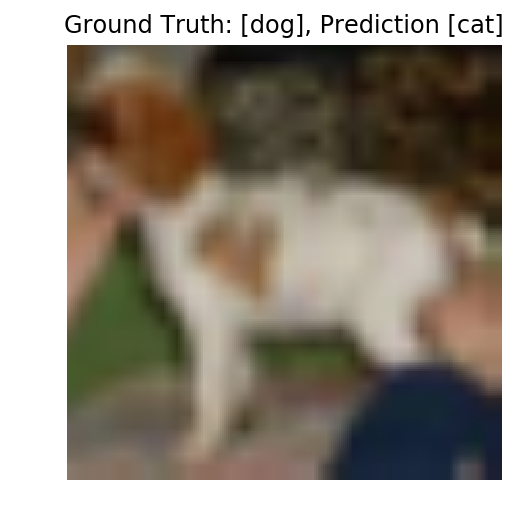

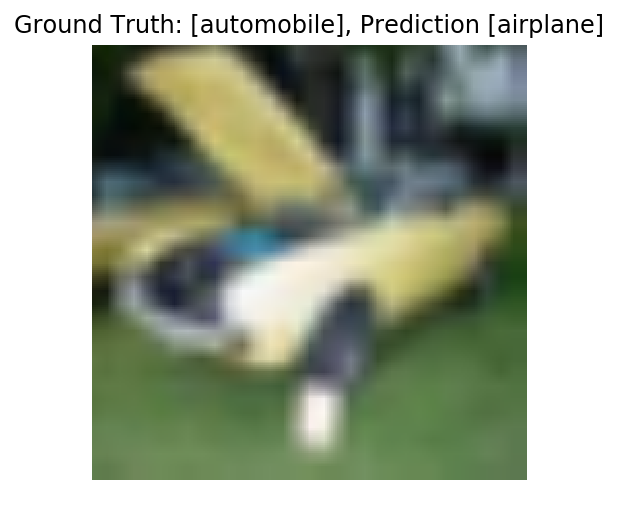

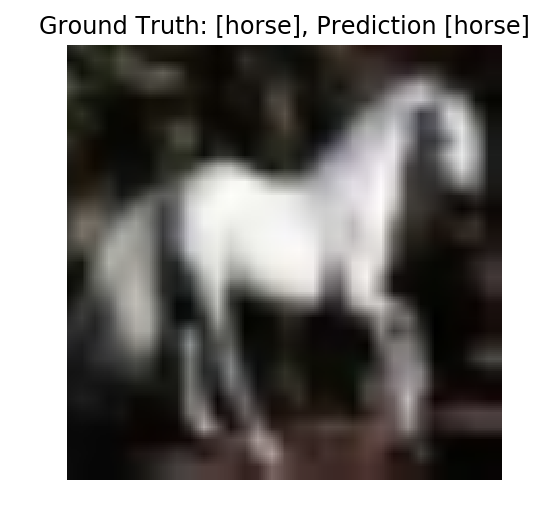

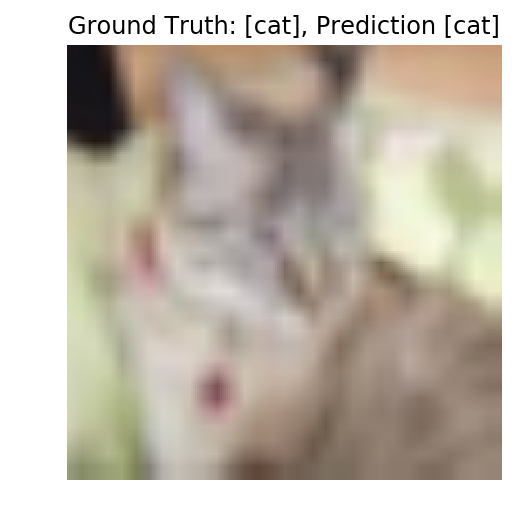

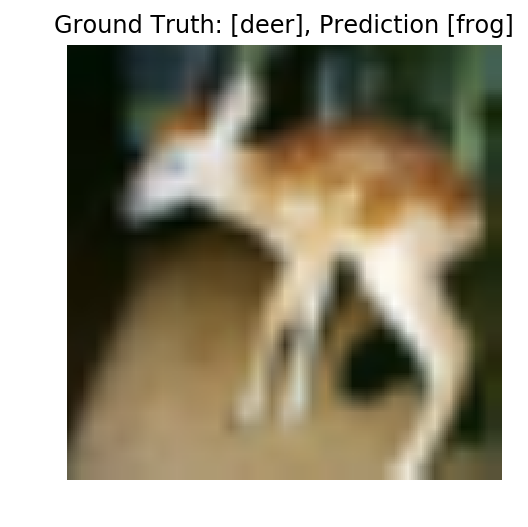

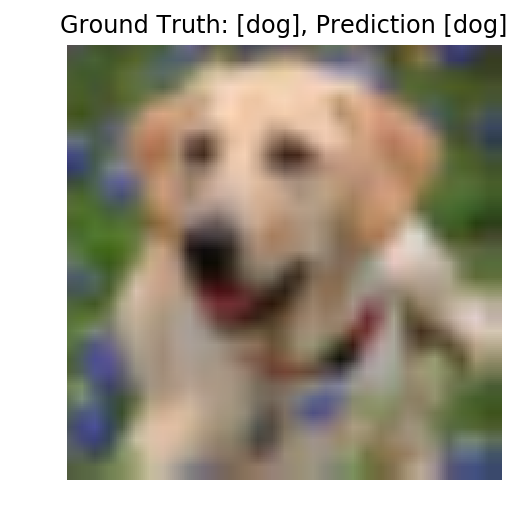

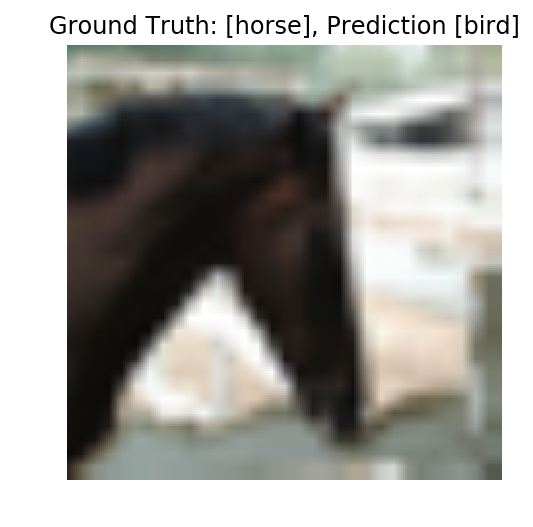

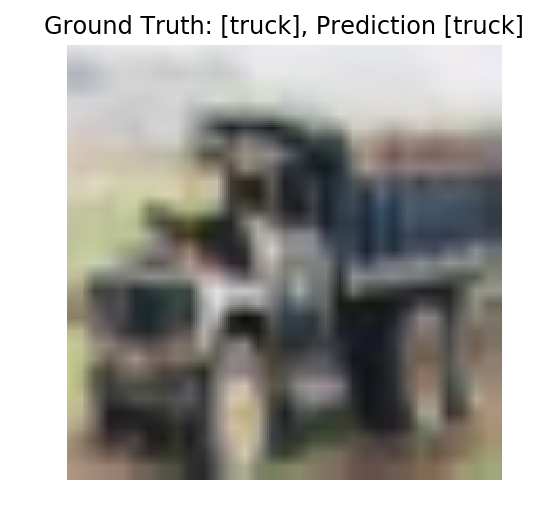

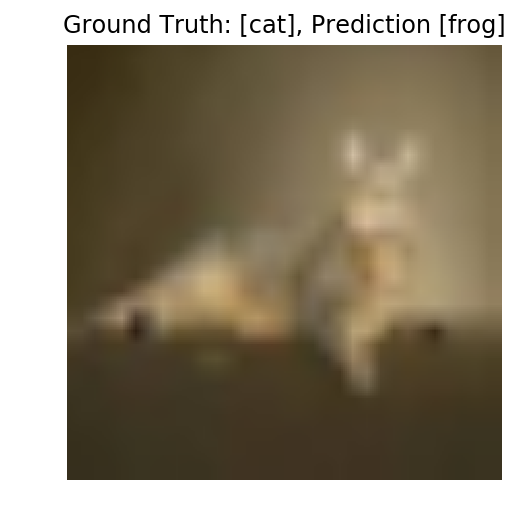

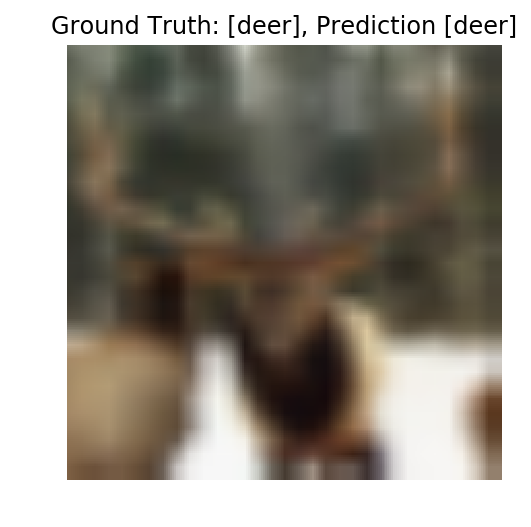

Overall accuracy 0.663


In [29]:
BATCH_SIZE = 10
TEST_SAMPLE_SIZE = 10000

all_batch_stats = []

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    test_dataset = get_dataset(
        os.path.join('tfrecord','cifar-10-test-tfrecord'), TEST_SAMPLE_SIZE)
    images, images_raw, labels = load_batch(
        test_dataset, BATCH_SIZE, INCEPTION_IMAGE_SIZE, INCEPTION_IMAGE_SIZE)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v1_arg_scope()):
        logits, _ = inception_v1(images, num_classes=test_dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(TRAINED_MODEL_DIR)
    init_fn = slim.assign_from_checkpoint_fn(checkpoint_path, slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            all_accuracy = []
            for i in range(int(TEST_SAMPLE_SIZE/BATCH_SIZE)):
                np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
                all_batch_stats.append((np_labels, np_probabilities))
                if i == 999: # show images 
                    for i in range(BATCH_SIZE): 
                        image = np_images_raw[i, :, :, :]
                        true_label = np_labels[i]
                        predicted_label = np.argmax(np_probabilities[i, :])
                        predicted_name = test_dataset.labels_to_names[predicted_label]
                        true_name = test_dataset.labels_to_names[true_label]

                        plt.figure()
                        plt.imshow(image.astype(np.uint8))
                        plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                        plt.axis('off')
                        plt.show()

# Accuracy over the whole test set
all_batch_accuracy = []
for labels, probs in all_batch_stats:
    for label, prob in zip(labels, probs):
            all_batch_accuracy.append(np.argmax(prob) == label)
print('Overall accuracy', np.mean(all_batch_accuracy))